In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data_augmentation import random_transform
from PIL import Image

from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras import applications
from keras.layers import Dense, Conv2D, MaxPooling2D, Reshape, Flatten, Input, merge, subtract, Lambda, Dropout
from keras import backend as K

Using TensorFlow backend.


In [2]:
resize_shape = (256, 256, 3)

In [3]:
data = pd.read_csv("data/train.csv")

In [4]:
len(data)

9850

# Look at examples 

In [5]:
data.head(10)

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3
5,0025e8c2.jpg,w_8b1ca89
6,0026a8ab.jpg,w_eaad6a8
7,0031c258.jpg,new_whale
8,0035632e.jpg,w_3d0bc7a
9,0037e7d3.jpg,w_50db782


In [6]:
image = Image.open('data/train/00022e1a.jpg')

In [7]:
np.array(image).shape

(500, 699)

In [8]:
# plt.imshow(image)
# plt.show()

In [9]:
new_image = np.repeat(np.expand_dims(image, axis=2),3, axis=2)

In [10]:
np.array(new_image).shape

(500, 699, 3)

In [11]:
def get_image(file, shape=(resize_shape[0],resize_shape[1])):
    image = Image.open('data/train/' + file)
    image = image.resize(shape)
    image = np.array(image)
    if len(image.shape) == 2:
        image = np.repeat(np.expand_dims(image, axis=2),3, axis=2)
    return image

In [12]:
file_list = data['Image']

In [13]:
image_list = [get_image(f) for f in file_list]

In [14]:
length_list = [len(image.shape) for image in image_list]

In [15]:
file_list[0]

'00022e1a.jpg'

In [16]:
data['image_array'] = image_list

In [17]:
data.head(4)

,Image,Id,image_array
0,00022e1a.jpg,w_e15442c,"[[[240, 240, 240], [229, 229, 229], [230, 230,..."
1,000466c4.jpg,w_1287fbc,"[[[198, 191, 185], [198, 191, 185], [194, 187,..."
2,00087b01.jpg,w_da2efe0,"[[[180, 180, 180], [178, 178, 178], [183, 183,..."
3,001296d5.jpg,w_19e5482,"[[[118, 139, 218], [119, 140, 219], [120, 141,..."


# Create Test and Train

In [18]:
from sklearn.utils import shuffle
data = shuffle(data)

test_proportion = 0.8
cutoff_index = int(len(data) * test_proportion)

training_data = data.iloc[:cutoff_index].reset_index(drop=True)
test_data = data.iloc[cutoff_index:].reset_index(drop=True)

In [19]:
from collections import Counter

training_counts = Counter(training_data['Id'])
training_data['Id_count'] = training_data.apply(lambda x: training_counts.get(x["Id"]), axis=1)

test_counts = Counter(test_data['Id'])
test_data['Id_count'] = test_data.apply(lambda x: test_counts.get(x["Id"]), axis=1)

In [20]:
from random import randint

# Create generator

In [31]:
def get_triple(data):
#     filtered = data[data['Id_count'] > 1].reset_index(drop=True)
    filtered = data[(data.Id_count > 1) & (data.Id != 'new_whale')].reset_index(drop=True)
    
    anchor_index = randint(0,len(filtered)-1)
    anchor_image = filtered['image_array'][anchor_index]
    anchor_id = filtered['Id'][anchor_index]   
    same_id = anchor_id
    relevant_indices = list(filtered.index[filtered['Id'] == anchor_id])
    same_index = np.random.choice(relevant_indices)
    same_image = filtered['image_array'][same_index]
    
    different_id = anchor_id
    while (anchor_id == different_id):
        different_index = randint(0,len(data)-1)
        different_id = data['Id'][different_index]
    
    different_image = data['image_array'][different_index]
    anchor_image = random_transform(anchor_image)
    same_image = random_transform(same_image)
    different_image = random_transform(different_image)
    return anchor_image, same_image, different_image

In [32]:
def triple_generator(batch_size, data, resize_shape):
    while True:
        anchor_batch = np.zeros((batch_size, resize_shape[0],resize_shape[1],resize_shape[2]))
        same_image_batch = np.zeros((batch_size, resize_shape[0],resize_shape[1],resize_shape[2]))
        different_image_batch = np.zeros((batch_size, resize_shape[0],resize_shape[1],resize_shape[2]))
        for i in range(batch_size):
                anchor_batch[i,:,:,:], same_image_batch[i,:,:,:], different_image_batch[i,:,:,:] = get_triple(data)

        batches = [anchor_batch, same_image_batch, different_image_batch]
        yield batches, np.ones(batch_size)

In [102]:
def get_triple(len_data, data_images, data_ids, len_filtered_data, filter, filtered_data_ids):
    
    anchor_index = randint(0,len_filtered_data-1)
    
    print("anchor index: ",anchor_index)
    
    print("len data_images[filter]: ",len(data_images[filter]))
    
    anchor_image = data_images[filter][anchor_index]
    
    
    anchor_id = filtered_data_ids[anchor_index]   
    same_id = anchor_id    
    relevant_indices = (data_ids == anchor_id)
    same_image = np.random.choice(data_images[relevant_indices])
    
    different_id = anchor_id
    while (anchor_id == different_id):
        different_index = randint(0,len_data-1)
        different_id = data_ids[different_index]
    
    different_image = data_images[different_index]
    
    anchor_image = random_transform(anchor_image)
    same_image = random_transform(same_image)
    different_image = random_transform(different_image)
    return anchor_image, same_image, different_image

In [103]:
def triple_generator(batch_size, data, resize_shape):
#     filtered = data[(data.Id_count > 1) & (data.Id != 'new_whale')].reset_index(drop=True)
    
    len_data = len(data)
    data_images = data['image_array']
    data_ids = data['Id']
    
    filter = (data['Id_count'] > 1) & (data_ids != 'new_whale')
    len_filtered_data = np.sum(filter)
#     filtered_data_images = filtered['image_array']
    filtered_data_ids = data_ids[filter]
    
    
    
    
    
    
    
    while True:
        anchor_batch = np.zeros((batch_size, resize_shape[0],resize_shape[1],resize_shape[2]))
        same_image_batch = np.zeros((batch_size, resize_shape[0],resize_shape[1],resize_shape[2]))
        different_image_batch = np.zeros((batch_size, resize_shape[0],resize_shape[1],resize_shape[2]))
        for i in range(batch_size):
                anchor_batch[i,:,:,:], same_image_batch[i,:,:,:], different_image_batch[i,:,:,:] = get_triple(
                    len_data, data_images, data_ids, len_filtered_data, filter, filtered_data_ids)

        batches = [anchor_batch, same_image_batch, different_image_batch]
        yield batches, np.ones(batch_size)
    
    
    
    
    

In [33]:
# data.head(5)

In [109]:
data_images = data['image_array']
filter = (data['Id'] == 'new_whale') & (data_ids != 'new_whale')

In [110]:
data_images[filter]

Series([], Name: image_array, dtype: object)

In [35]:
np.random.choice(data_images[data_ids == 'w_3d187b5']).shape

(256, 256, 3)

In [106]:
data_images = data['image_array']

In [ ]:
data_images = data['image_array']

In [104]:
gen = triple_generator(16, training_data, resize_shape)

In [105]:
genned = next(gen)

anchor index:  786
len data_images[filter]:  5050


KeyError: 786

In [81]:
generated_image = genned[0][0][16]

IndexError: index 16 is out of bounds for axis 0 with size 16

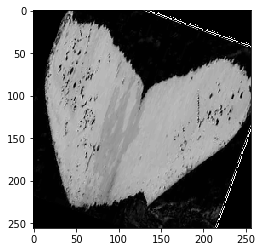

In [83]:


plt.imshow(generated_image)
plt.show()

In [88]:
list = np.array([1,2,3,4,5])

filter = list%2 == 0

list[filter][1]

4

# Create the network

In [ ]:
input_shape = resize_shape

anchor_input = Input(input_shape)
same_category_input = Input(input_shape)
different_category_input = Input(input_shape)

In [ ]:
def bpr_triplet_loss(X):    
    alpha = 0.1

    anchor_embedding, same_embedding, different_embedding = X
    
    positive_distance = K.square(anchor_embedding - same_embedding)
    negative_distance = K.square(anchor_embedding - different_embedding)
    
    positive_distance = K.mean(positive_distance, axis=-1, keepdims=True)
    negative_distance = K.mean(negative_distance, axis=-1, keepdims=True)
    
    loss = K.maximum(0.0, alpha + positive_distance - negative_distance)
   
    return K.mean(loss)

#Something like this:
def triplet_loss(inputs, dist='sqeuclidean', margin='maxplus', alpha=0.1):
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.mean(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.mean(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = K.maximum(0.0, alpha + loss)
    elif margin == 'softplus':
        loss = K.log(alpha + K.exp(loss))
    return K.mean(loss)


# transfer_learning_net = applications.VGG19(weights = "imagenet", include_top=False, input_shape = resize_shape)
transfer_learning_net = applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=resize_shape)

for layer in transfer_learning_net.layers:
    layer.trainable = False
    
x = transfer_learning_net.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="linear")(x)
predictions = Lambda(lambda x: K.l2_normalize(x,axis=1))(x)
embedding = Model(input = transfer_learning_net.input, output = predictions)      

anchor = embedding(anchor_input)
same = embedding(same_category_input)
different = embedding(different_category_input)

loss = merge(
        [anchor, same, different],
        mode=bpr_triplet_loss,
        name='loss',
        output_shape=(1, ))
    
siamese_net = Model(input=[anchor_input,same_category_input, different_category_input],output=loss)

In [ ]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred - 0 * y_true)

In [ ]:
LEARNING_RATE = 10
siamese_net.compile(loss=identity_loss,optimizer=SGD(LEARNING_RATE))
# siamese_net.compile(loss=identity_loss,optimizer=Adam())

# Run the network

In [ ]:
from keras.optimizers import Adam, SGD

In [ ]:
BATCH_SIZE = 16
training_data_generator = triple_generator(BATCH_SIZE, training_data, resize_shape)

In [ ]:
history = siamese_net.fit_generator(training_data_generator,
                                    verbose=1, 
                                    epochs=3, 
                                    steps_per_epoch=100,
                                    workers=16,
                                    use_multiprocessing=True)

# Loss function 

In [ ]:
plt.plot(history.history['loss'])
plt.title("Loss function")
plt.xlabel("epochs")
plt.show()

# Evaluation 

In [ ]:
evaluation_data_generator = triple_generator(BATCH_SIZE, test_data, resize_shape)
evaluation_steps = 20
metric_names = siamese_net.metrics_names
metric_values = siamese_net.evaluate_generator(evaluation_data_generator, steps=evaluation_steps)
print("Metric names", metric_names)
print("Metric values", metric_values)

# Save weights

In [ ]:
import time
import os

now = time.strftime('%Y.%m.%d %H:%M:%S')
directory = "weights/" + now + "/"
if not os.path.exists(directory):
    os.makedirs(directory)


siamese_net.save_weights(directory + "siamese_weights")
convnet.save_weights(directory + "convnet_weights")

# Sub

In [ ]:
data = pd.read_csv("data/train.csv")
file_list = data['Image']
image_list = [get_image(f) for f in file_list]

In [ ]:
id_list = data['Id']

In [ ]:
embedding_list = convnet.predict(np.stack(image_list))

In [ ]:
def get_sub_image(file, shape=(resize_shape[0],resize_shape[1])):
    image = Image.open('data/test/' + file)
    image = image.resize(shape)
    image = np.array(image)
    if len(image.shape) == 2:
        image = np.stack([image]*3,axis=2) 
    return image


sample_sub = pd.read_csv("data/sample_submission.csv")
submission_file_list = sample_sub['Image']
submission_image_list = [get_sub_image(f) for f in submission_file_list]

In [ ]:
submission_embedding_list = convnet.predict(np.stack(submission_image_list))

In [ ]:
X = [1,2,3,4]
Y = [9,8,2,3]

[x for (y,x) in sorted(zip(Y,X), key=lambda pair: pair[0])]

In [ ]:
def remove_duplicates(li):
    my_set = set()
    filtered = []
    for e in li:
        if e not in my_set:
            filtered.append(e)
            my_set.add(e)
    return filtered


def classify(image_embedding, embedding_list, id_list, num_categories=5):
    image_embedding = np.expand_dims(image_embedding, axis=0)
    stacked_image = np.repeat(image_embedding,len(embedding_list),axis=0)
    square_differences = (stacked_image - embedding_list)**2
    scores = np.sum(square_differences, axis=1)    
    sorted_ids = [x for (y,x) in sorted(
        zip(scores,id_list), key=lambda pair: pair[0])]
    
    return ' '.join(remove_duplicates(sorted_ids[0:num_categories]))
    

In [ ]:
classify(embedding_list[0], embedding_list, id_list)

In [ ]:
data.head(10)

In [ ]:
submission_embedding_list

In [ ]:
submission_embedding_list[4]

In [ ]:
submission_prediction_list = [classify(image_embedding, embedding_list, id_list) for image_embedding in submission_embedding_list]

In [ ]:
submission = pd.DataFrame({'Image': submission_file_list, 'Id': submission_prediction_list}, columns=['Image','Id'])

In [ ]:
submission.head(10)

In [ ]:
submission.to_csv("results/submission.csv",index=False)

In [ ]:
np.sort(id_list)

In [ ]:
# import tensorflow as tf
# x = tf.convert_to_tensor(np.array([1,2,3,4]), dtype=np.float32)

K.mean(x).value